# Pneumonia X-Ray Image Classification: Modeling

Authors:
- Arthur Kim
    - Github: arthurk2323
- Mia Fryer
    - Github: miazfryer
- Ian Sharff
    - Github: iansharff
___

## Business Understanding

## Data Understanding and Exploration

In [1]:
import os
import sys
import pickle
import PIL
from PIL import Image
import io
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model

import tools.visualizations as vis
import tools.misc as misc

In [2]:
TRAIN_PATH = 'data/split/train'
VAL_PATH = 'data/split/val'
TEST_PATH = 'data/split/test'

BATCH_SIZE = 32
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Change for test runs
EPOCHS = 1

In [3]:
counts = misc.count_files([TRAIN_PATH, VAL_PATH, TEST_PATH])


TRAIN
-------------------------
	PNEUMONIA: 2564
	NORMAL: 950

	SUBTOTAL: 3514
VAL
-------------------------
	PNEUMONIA: 855
	NORMAL: 317

	SUBTOTAL: 1172
TEST
-------------------------
	PNEUMONIA: 854
	NORMAL: 316

	SUBTOTAL: 1170
-------------------------
TOTAL: 5856 files


In [4]:
counts

{'train': 3514, 'val': 1172, 'test': 1170}

In [5]:
gen_params = {
    'target_size': (64, 64),
    'color_mode': 'grayscale',
    'class_mode': 'binary',
}

In [6]:
# Get all the data in the directory data/train (2564+950 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_PATH, 
    batch_size=counts['train'],
    **gen_params
)

# Get all the data in the directory data/val (855+317 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_PATH, 
    batch_size=counts['val'],
    **gen_params
)

# Get all the data in the directory data/test (854+316 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_PATH,
    batch_size=counts['test'],
    **gen_params
)

# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [7]:
# Display the shape of the image and label arrays (this cell may take a while to load)
print('TRAIN\n' + '-'*50)
print(f'\ttrain_images shape: {train_images.shape}')
print(f'\ttrain_labels shape: {train_labels.shape}')
print('\nVALIDATION\n' + '-'*50)
print(f'\tval_images shape: {val_images.shape}')
print(f'\tval_labels shape: {val_labels.shape}')
print('\nTEST\n' + '-'*50)
print(f'\ttest_images shape: {test_images.shape}')
print(f'\ttest_labels shape: {test_labels.shape}')
    

TRAIN
--------------------------------------------------
	train_images shape: (3514, 64, 64, 1)
	train_labels shape: (3514,)

VALIDATION
--------------------------------------------------
	val_images shape: (1172, 64, 64, 1)
	val_labels shape: (1172,)

TEST
--------------------------------------------------
	test_images shape: (1170, 64, 64, 1)
	test_labels shape: (1170,)


In [8]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     TRAIN_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     VAL_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     TEST_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

In [9]:
class_names = {v: k for k, v in train_generator.class_indices.items()}
print(class_names)

{0: 'NORMAL', 1: 'PNEUMONIA'}


In [10]:
norm_samples = []
pneu_samples = []
i = 0
while len(norm_samples) < 3 and len(pneu_samples) < 3:
    img = train_images[i]
    lab = train_labels[i]
    if len(norm_samples) != 3 and lab == 0:
        norm_samples.append(img)
        i += 1
    elif len(pneu_samples) != 3 and lab == 1:
        pneu_samples.append(img)
        i += 1

with plt.style.context('images/presentation.mplstyle'):
    fig, axes = plt.subplots(2, 3, figsize=(10, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < 3:
            ax.imshow(norm_samples[i], cmap=plt.cm.binary)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('NORMAL')
        else:
            ax.imshow(pneu_samples[i-4], cmap=plt.cm.binary)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('PNEUMONIA', color='darkred')
    fig.tight_layout()
    plt.axis('off')
    plt.show()

IndexError: list index out of range

## Model Building and Evaluation

### Dummy Model

In [11]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

In [12]:
dummy_clf.score(train_images, train_labels)

0.7296528173022196

In [13]:
dummy_clf.score(val_images,val_labels)

0.7295221843003413

In [14]:
dummy_clf.score(test_images,test_labels)

0.7299145299145299

### Model 1: Baseline Neural Network

In [15]:
np.random.seed(123)
model1 = models.Sequential()
model1.add(layers.Flatten(input_shape=(64, 64, 1)))
model1.add(layers.Dense(2, activation='relu'))

In [16]:
model1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history1 = model1.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

110/110 [==============================] - 0s 3ms/step - loss: 4.0995 - acc: 0.7389 - val_loss: 4.1246 - val_acc: 0.7295


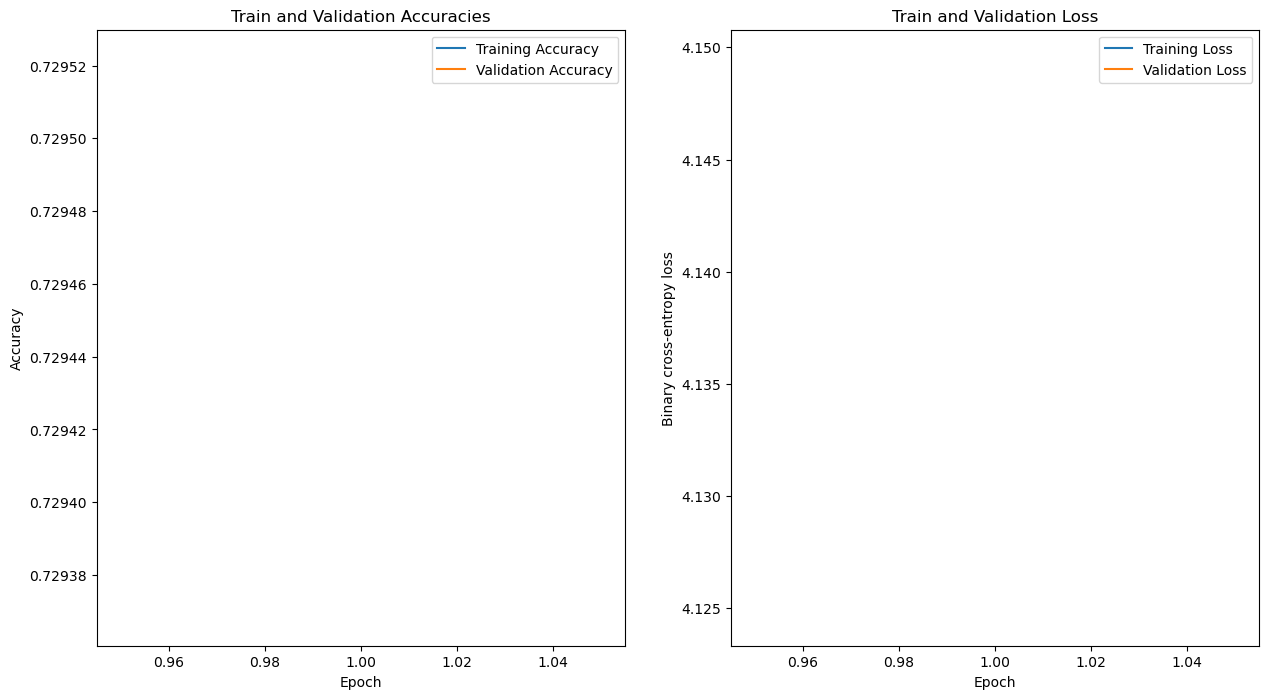

In [17]:
vis.plot_loss_accuracy(history1)

In [18]:
results_train = model1.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 606us/step - loss: 4.1226 - acc: 0.7297


In [19]:
results_test = model1.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 644us/step - loss: 4.1186 - acc: 0.7299


In [20]:
results_train

[4.122589111328125, 0.7296528220176697]

In [21]:
results_test

[4.118597984313965, 0.7299145460128784]

### Model 2: Neural Network with Dense Layers

In [25]:
np.random.seed(123)
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(64, 64, 1)))
model2.add(layers.Dense(200, activation='relu'))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(25, activation='relu'))
model2.add(layers.Dense(7, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

110/110 [==============================] - 1s 7ms/step - loss: 0.6238 - accuracy: 0.7323 - val_loss: 0.5410 - val_accuracy: 0.7295


In [28]:
results_train = model2.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 2ms/step - loss: 0.5425 - accuracy: 0.7297


In [30]:
results_test = model2.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 2ms/step - loss: 0.5446 - accuracy: 0.7299


In [31]:
results_train

[0.5424644947052002, 0.7296528220176697]

In [32]:
results_test

[0.5446419715881348, 0.7299145460128784]

### Model 3: Neural Network with Dense and Drop Layers

In [33]:
np.random.seed(123)
model3 = models.Sequential()
model3.add(layers.Flatten(input_shape=(64, 64, 1)))
model3.add(layers.Dense(200, activation='relu'))
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(50, activation='relu'))
model3.add(layers.Dense(25, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(7, activation='relu'))
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [35]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

110/110 [==============================] - 1s 5ms/step - loss: 0.6098 - accuracy: 0.7122 - val_loss: 0.5320 - val_accuracy: 0.7295


In [38]:
results_train = model3.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 2ms/step - loss: 0.5325 - accuracy: 0.7297


In [39]:
results_test = model3.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 2ms/step - loss: 0.5355 - accuracy: 0.7299


In [40]:
results_train

[0.5325213074684143, 0.7296528220176697]

In [41]:
results_test

[0.5354881882667542, 0.7299145460128784]

### Model 4: Convolutional Neural Network (CNN)

(3514, 64, 64, 1)

In [42]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [43]:
history4 = model4.fit(train_images,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_images, val_labels))

110/110 [==============================] - 7s 63ms/step - loss: 0.6331 - acc: 0.6543 - val_loss: 0.5849 - val_acc: 0.7295


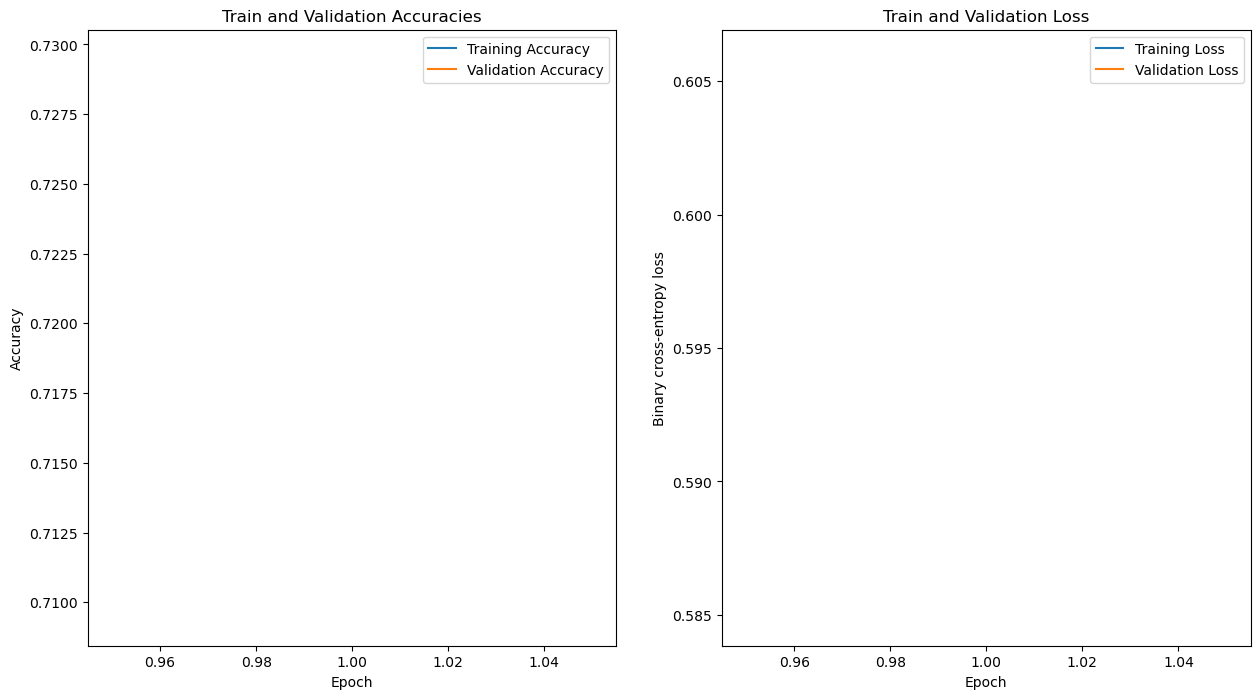

In [45]:
vis.plot_loss_accuracy(history4)
plt.show()

In [48]:
results_train = model4.evaluate(train_images, train_labels)

110/110 [==============================] - 2s 17ms/step - loss: 0.5854 - acc: 0.7297


In [49]:
results_test = model4.evaluate(test_images, test_labels)

37/37 [==============================] - 1s 17ms/step - loss: 0.5856 - acc: 0.7299


In [50]:
results_train

[0.5854197144508362, 0.7296528220176697]

In [51]:
results_test

[0.5855543613433838, 0.7299145460128784]

### Model 5: Base CNN with Focal Loss to solve class imbalancement 

In [ ]:
#pip install focal-loss

In [52]:
from focal_loss import BinaryFocalLoss

In [70]:
model_fl = models.Sequential()
model_fl.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Flatten())
model_fl.add(layers.Dense(64, activation='relu'))
model_fl.add(layers.Dense(1, activation='sigmoid'))

model_fl.compile(
    loss=BinaryFocalLoss(gamma=2),
    optimizer= 'sgd',
    metrics=['acc']
)

In [71]:
train_images.shape

(3514, 64, 64, 1)

In [72]:
val_images.shape

(1172, 64, 64, 1)

In [73]:
val_labels.shape

(1172,)

In [74]:
history_base_fl = model_fl.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels)
)

110/110 [==============================] - 7s 66ms/step - loss: 0.1559 - acc: 0.7024 - val_loss: 0.1458 - val_acc: 0.7295


In [ ]:
# test_x_fl, test_y_fl = next(test_generator)

# results_test = model_fl.evaluate(test_x_fl, test_y_fl)

In [75]:
model_fl.summary()  

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2304)             

In [95]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(train_labels), class_weight.compute_class_weight('balanced',np.unique(train_labels), train_labels)))

/Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1. 0. 1. ... 1. 1. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [97]:
class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels,
)

array([1.84947368, 0.68525741])

### Model 6: Transfer Learning - ResNet50V2

In [79]:
from tensorflow.keras.applications import ResNet50V2

In [94]:
resnet50 = ResNet50V2(
    weights="imagenet",
    input_shape=(64, 64, 1),
    include_top=False
)

ValueError: The input must have 3 channels; got `input_shape=(64, 64, 1)`

In [90]:
model2 = models.Sequential()

model2.add(resnet50)    
model2.add(layers.Flatten())
model2.add(layers.Dense(units = 128, activation = "relu"))
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(units = 1, activation = "sigmoid"))

In [91]:
resnet50.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model2.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model2.trainable_weights))

resnet50v2 False
flatten_9 True
dense_33 True
dropout_4 True
dense_34 True
4


In [92]:
model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [93]:
hist2 = model2.fit(
    train_images,
    validation_data=(val_images, val_labels),
    epochs=5
)

Epoch 1/5


ValueError: in user code:

    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_11: expected shape=(None, 220, 220, 3), found shape=(None, 64, 64, 1)


In [ ]:
test_results2 = model2.evaluate(test2)

In [ ]:
model2.summary()

### Model 7: CNN with Image Augumentation 

In [ ]:
train_datagen_aug = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3,
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

In [ ]:
train_aug = train_datagen_aug.flow_from_directory(train_path,
                                               batch_size=128,
                                               target_size=(64,64),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

test_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_path, 
        target_size=(64, 64), 
        batch_size = BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
val_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_path, 
        target_size=(64, 64),
        batch_size = BATCH_SIZE,
        class_mode='binary')

In [ ]:
model_aug = models.Sequential()
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(64, activation='relu'))
model_aug.add(layers.Dense(1, activation='sigmoid'))

model_aug.compile(loss=BinaryFocalLoss(gamma=2),
              optimizer= 'sgd',
              metrics=['acc'])

In [ ]:
history_aug = model_aug.fit(
    train_aug, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_aug
)

In [ ]:
test_results_aug = model_aug.evaluate(test_aug)

In [ ]:
model_aug.summary()

## Analysis, Conclusions, and Future Work